In [182]:
# Data manipulation
import pandas as pd
from pandas import DataFrame
import numpy as np
from time import time, sleep

# Ploting and image operations
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from PIL import Image
from PIL import ImageEnhance
import PIL.ImageOps
import cv2
from io import BytesIO
import urllib
from urllib.request import urlopen
import urllib.error
import os
import scipy.misc

# Sklearn
from sklearn import preprocessing, metrics

# Keras libraries
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Conv3D, MaxPooling3D, GlobalAveragePooling2D
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K

# WebScrapping

In [183]:
# Se leen los datos del archivo csv
data = pd.read_csv("MovieGenre.csv", encoding ="ISO-8859-1")
data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [184]:
print(data.shape)
data.isnull().sum()

(40108, 6)


imdbId          0
Imdb Link       0
Title           0
IMDB Score     48
Genre         145
Poster        725
dtype: int64

In [185]:
# Se remueven las peliculas que no cuentan con alguno de los datos especificados
# Como la cantidad a eliminar es mucho menor a la cantidad total de los datos,
# se considera que el resultado total no se ve afectado en gran medida.
data = data.dropna(subset=["Genre"])
data = data.dropna(subset=["Poster"])
data = data.dropna(subset=["IMDB Score"])
data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [186]:
data.isnull().sum()

imdbId        0
Imdb Link     0
Title         0
IMDB Score    0
Genre         0
Poster        0
dtype: int64

In [187]:
data = data[:20]
data.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [188]:
# Se obtendrá el director, escritor y cast por medio de un Scraping de la pag. de IMDB
# Por último, se obtendrá el resumen como data de texto.

import requests
from bs4 import BeautifulSoup
import csv
import time

links = data['Imdb Link']
new_data = {}
new_data['Poster'] = data['Poster']
new_data['IMDB Score'] = data['IMDB Score']
new_data['Directed by'] = []
new_data['Writing Credits'] = []
new_data['Cast'] = []
new_data['Produced by'] = []
new_data['Music by'] = []
new_data['Summary'] = []

keys = ["Directed by", "Writing Credits", "Cast", "Produced by", "Music by"]            

def get_ids(content):
    return [block['href'].split('/')[2] for block in content.find_all("a")]

def get_credits_info(new_data, link):
    try:
        page = requests.get(link + "/fullcredits")
        soup = BeautifulSoup(page.content, "html.parser")    
        full_credits = soup.find("div", {"id": "fullcredits_content"})            
        block_titles = [title.contents[0].strip() for title in full_credits.find_all("h4")]
        block_content = full_credits.find_all("table")
        
        for key in keys:
            found_key = False
            for title, content in zip(block_titles, block_content):                
                if title == key:            
                    found_key = True
                    elements = "|".join(get_ids(content)[:5])        
                    if title == "Directed by" or \
                        title == "Writing Credits" or \
                        title == "Produced by" or \
                        title == "Music by":                            
                        new_data[title].append(elements)

                    if title == "Cast":
                        elements = "|".join([block.find('a')['href'].split('/')[2]
                                    for block in content.find_all("td", {"itemprop":"actor"})][:5])
                        new_data['Cast'].append(elements)
            
            if not found_key:
                new_data[key].append("")
    except:
        print("Error en el link: ", link + "/fullcredits")
        for key in keys:
            new_data[key].append("")
            
def get_text_info(new_data, link):
    try:
        page = requests.get(link + "/plotsummary")
        soup = BeautifulSoup(page.content, "html.parser")
        block = soup.find("ul", {"id":"plot-summaries-content"})    
        summaries = " ".join([summary.find("p").get_text() for summary in block.find_all("li")][:2])
        new_data['Summary'].append(summaries)
    except:
        print("Error en el link: ", link + "/plotsummary")
        new_data['Summary'].append("")
    
        
for link in links:
    time.sleep(1)
    get_credits_info(new_data, link)
    get_text_info(new_data, link)          


In [189]:
for key in new_data:
    data[key] = new_data[key]

In [190]:
directors = data['Directed by'].str.split('|').apply(pd.Series).astype(str)
directors.rename(columns={0:'director1', 1:'director2'}, inplace=True)
directors = directors.iloc[:, 0: 2]

writers = data['Writing Credits'].str.split('|').apply(pd.Series).astype(str)
writers.rename(columns={0:'writer1', 1:'writer2'}, inplace=True)
writers = writers.iloc[:, 0: 2]

cast = data['Cast'].str.split('|').apply(pd.Series).astype(str)
cast.rename(columns={0:'cast1', 1:'cast2', 2:'cast3', 3:'cast4', 4:'cast5'}, inplace=True)
cast = cast.iloc[:,0:5]

producers = data['Produced by'].str.split('|').apply(pd.Series).astype(str)
producers.rename(columns={0:'producer1', 1:'producer2'}, inplace=True)
producers = producers.iloc[:,0:2]

composers = data['Music by'].str.split('|').apply(pd.Series).astype(str)
composers.rename(columns={0:'composer1', 1:'composer2'}, inplace=True)
composers = composers.iloc[:,0:2]

data = pd.concat([data[['imdbId','Title','Genre','Poster', 'Summary']], directors, writers, cast, producers, composers], axis=1)
data.head()

,imdbId,Title,Genre,Poster,Summary,director1,director2,writer1,writer2,cast1,cast2,cast3,cast4,cast5,producer1,producer2,composer1
0,114709,Toy Story (1995),Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,A little boy named Andy loves to be in his roo...,nm0005124,nan,nm0005124,nm0230032,nm0000158,nm0000741,nm0725543,nm0001815,nm0001728,nm0036366,nm0146216,nm0005271
1,113497,Jumanji (1995),Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,After being trapped in a jungle board game for...,nm0002653,nan,nm0378144,nm0852430,nm0000245,nm0404993,nm0000379,nm0682300,nm0001372,nm0181202,nm0276059,nm0000035
2,113228,Grumpier Old Men (1995),Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,Things don't seem to change much in Wabasha Co...,nm0222043,nan,nm0425756,nm0425756,nm0000527,nm0000493,nm0000047,nm0000268,nm0580565,nm0075828,nm0204862,nm0006293
3,114885,Waiting to Exhale (1995),Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,This story based on the best selling novel by ...,nm0001845,nan,nm0573334,nm0573334,nm0001365,nm0000291,nm0222643,nm0005375,nm0002138,nm0060103,nm0433845,nm0004892
4,113041,Father of the Bride Part II (1995),Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,"In this sequel to ""Father of the Bride"", Georg...",nm0796124,nan,nm0352443,nm0329304,nm0000188,nm0000473,nm0001737,nm0931090,nm0627624,nm0062071,nm0088692,nm0006293


In [191]:
import urllib
from urllib.request import urlretrieve

path = "/Img/poster"

for idx, link in enumerate(data['Poster']):
    urlretrieve(link, path + str(idx) + ".jpg")

# Procesamiento de Datos

In [135]:
# Se leen los datos del archivo csv luego de hacer el WebScrapping
data = pd.read_csv("Data.csv", encoding ="ISO-8859-1",na_values=" NaN")
data.fillna('', inplace=True)
data.head()

,Unnamed: 0,imdbId,Title,Genre,Poster,Summary,director1,director2,writer1,writer2,cast1,cast2,cast3,cast4,cast5,producer1,producer2,composer1,composer2,Unnamed: 19
0,0,114709,Toy Story (1995),Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,A little boy named Andy loves to be in his roo...,nm0005124,,nm0005124,nm0230032,nm0000158,nm0000741,nm0725543,nm0001815,nm0001728,nm0036366,nm0146216,nm0005271,,
1,1,113497,Jumanji (1995),Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,After being trapped in a jungle board game for...,nm0002653,,nm0378144,nm0852430,nm0000245,nm0404993,nm0000379,nm0682300,nm0001372,nm0181202,nm0276059,nm0000035,,
2,2,113228,Grumpier Old Men (1995),Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,Things don't seem to change much in Wabasha Co...,nm0222043,,nm0425756,nm0425756,nm0000527,nm0000493,nm0000047,nm0000268,nm0580565,nm0075828,nm0204862,nm0006293,,
3,3,114885,Waiting to Exhale (1995),Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,This story based on the best selling novel by ...,nm0001845,,nm0573334,nm0573334,nm0001365,nm0000291,nm0222643,nm0005375,nm0002138,nm0060103,nm0433845,nm0004892,,
4,4,113041,Father of the Bride Part II (1995),Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,"In this sequel to ""Father of the Bride"", Georg...",nm0796124,,nm0352443,nm0329304,nm0000188,nm0000473,nm0001737,nm0931090,nm0627624,nm0062071,nm0088692,nm0006293,,


In [136]:
genre={}
genre_dict=[]
for x in data.index:
    genre[x]=data['Genre'][x]
    row = genre[x].split("|")
    for y in row:
        if y not in genre_dict and y != "":
            genre_dict.append(y)
            
genre_dict = sorted(genre_dict)
genre_dict

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

In [137]:
movie_dict=[]
frame = np.zeros((len(data),len(genre_dict)))
for x in range(len(data)):
    for y in range(len(genre_dict)):
        if genre_dict[y] in data['Genre'][x]:
            frame[x, y] = 1
df = DataFrame(frame, index=data.index, columns=genre_dict)
df.astype(int)
df.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
genres = df
corrmat = genres.corr()
corrmat.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
Action,1.000000,0.277976,-0.025063,-0.069995,-0.135529,0.163815,-0.072735,-0.204706,-0.065998,-0.002470,...,-0.096919,-0.055597,-0.070896,-0.185252,0.145366,-0.020705,-0.034326,0.099544,-0.020844,-0.023237
Adventure,0.277976,1.000000,0.249492,-0.046469,-0.040112,-0.118313,-0.059940,-0.211865,0.206341,0.066669,...,-0.084633,-0.041249,-0.083607,-0.150099,0.047072,-0.004738,-0.045592,-0.057835,-0.049806,0.010846
Animation,-0.025063,0.249492,1.000000,-0.038921,0.023305,-0.070597,-0.030400,-0.127398,0.192466,0.034322,...,-0.009198,-0.011954,-0.046231,-0.089731,-0.022220,0.170348,-0.024852,-0.065933,-0.029874,-0.021690
Biography,-0.069995,-0.046469,-0.038921,1.000000,-0.135045,-0.040317,0.151883,0.109696,-0.052510,-0.057216,...,0.078301,-0.003769,-0.055558,-0.045578,-0.060111,-0.011275,0.058730,-0.078894,0.002792,-0.018815
Comedy,-0.135529,-0.040112,0.023305,-0.135045,1.000000,-0.078264,-0.110926,-0.257221,0.086259,-0.001019,...,0.023699,0.070746,-0.142515,0.105205,-0.115226,0.011173,-0.009745,-0.248786,-0.083561,-0.046653


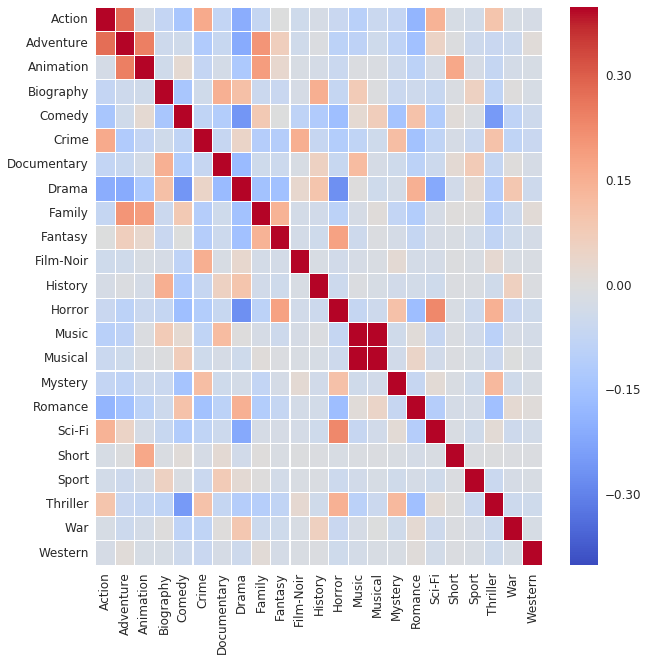

In [139]:
# set appropriate font and dpi
sns.set(font_scale=1.2)
# plot heatmap
plt.figure(figsize = (10,10))
ax = sns.heatmap(corrmat,linewidths=.1, vmin=-0.4, vmax=0.4, cmap="coolwarm")

plt.show()

In [140]:
# generate new Y variable -- number of genres
genres['num_genres'] = genres.ix[:, 1:19].sum(axis=1)
genres.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Thriller,War,Western,num_genres
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [141]:
genres.shape

(3999, 24)

In [142]:
poster_df = data['Poster']
poster_df.shape

(3999,)

In [143]:
imdbId_df = data['imdbId']
imdbId_df.shape

(3999,)

In [144]:
newposter_df = []
for i in range(poster_df.shape[0]):
    if(poster_df[i]!=''):
        newposter_df.append(poster_df[i])
len(newposter_df)

3999

In [ ]:

X_data = []
count=0
for i in range(genres.shape[0]):
    ind = 0
    try:
        file = urlopen(newposter_df[i])
    except urllib.error.HTTPError as e:
        if e.code == 404:
            ind = 1
        else:
            ind = 1
    if ind == 0:
        img = plt.imread(file, format='jpg')
        X_data.append(img)             

In [66]:
genres_dirs = genres.columns.tolist()[0:-1]
genres_dirs

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

# Etiquetado de Datos para clasificación CNN

In [161]:

for i in range(len(genres_dirs)):
    nuevaruta = r'data/poster_genre/'+genres_dirs[i] 
    if not os.path.exists(nuevaruta): os.makedirs(nuevaruta)

In [93]:

ruta = 'data/poster_genre/'
for i in range(len(X_data)):
    for j in range(len(genres_dirs)):
        if(genres[genres_dirs[j]][i] == 1.0):
            ruta_especifica = ruta + genres_dirs[j] + "/" + str(imdbId_df[i]) + ".jpg"
            scipy.misc.imsave(ruta_especifica, X_data[i])

In [155]:
DATA_PATH = "data/poster_genre/"
SAVE_PATH="data/poster_genre_resize/"
VALIDATION_PERCENT = .2
TEST_PERCENT = .2
IMAGE_WIDTH = 154
IMAGE_HEIGHT=154
IMAGE_SIZE=154
NUM_CHANNELS = 3 # RGB channels
PIXEL_DEPTH = 255.0
NUM_GENRES = 19
NUM_ROWS=1000
PARTITION_TEST = False

In [25]:
imdb_index_dict={}
for i in range(data.shape[0]):
    imdb_index_dict[data.iloc[i,0]]=i

In [28]:
def to_rgb(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, :] = im[:, :, np.newaxis]
    return ret
def read_image_from_file(file_path):
    img = Image.open(file_path).convert('RGB')
    img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT), Image.ANTIALIAS) #downsample image
    pixel_values = np.array(img.getdata())
    return np.reshape(pixel_values, [IMAGE_WIDTH,IMAGE_HEIGHT, NUM_CHANNELS])
def make_dataset_arrays(num_rows=NUM_ROWS,label=2):
    data = np.ndarray((num_rows, IMAGE_WIDTH,IMAGE_HEIGHT, NUM_CHANNELS), dtype=np.float32)
    labels = np.ndarray((num_rows, NUM_GENRES), dtype=np.int32)
    if label==3:
        single_label=np.ndarray((num_rows, NUM_GENRES), dtype=np.int32)
        return data, labels, single_label
    else:
        return data, labels
def scale_pixel_values(dataset):
    return (dataset - PIXEL_DEPTH / 2.0) / PIXEL_DEPTH

In [162]:
directory_list = list()
for root, dirs, files in os.walk(DATA_PATH, topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))
print(directory_list)

['data/poster_genre/Musical', 'data/poster_genre/Film-Noir', 'data/poster_genre/Action', 'data/poster_genre/Sci-Fi', 'data/poster_genre/Music', 'data/poster_genre/Crime', 'data/poster_genre/Biography', 'data/poster_genre/Mystery', 'data/poster_genre/Romance', 'data/poster_genre/Drama', 'data/poster_genre/Family', 'data/poster_genre/Animation', 'data/poster_genre/History', 'data/poster_genre/Fantasy', 'data/poster_genre/Comedy', 'data/poster_genre/Short', 'data/poster_genre/Western', 'data/poster_genre/Adventure', 'data/poster_genre/Documentary', 'data/poster_genre/Horror', 'data/poster_genre/Sport', 'data/poster_genre/Thriller', 'data/poster_genre/War']


In [164]:

label_order=genres.columns.tolist()[1:]
label_dict={}
for i in range(len(label_order)):
    label_dict[label_order[i]]=i
for d in directory_list:
    genre_name=d.split('/')[2]
    file_list = []
    for (dirpath, dirnames, filenames) in os.walk(d):
        file_list.extend(filenames)    
    print(genre_name,len(file_list))

Musical 30
Film-Noir 20
Action 500
Sci-Fi 200
Music 70
Crime 220
Biography 10
Mystery 150
Romance 500
Drama 650
Family 70
Animation 70
History 20
Fantasy 40
Comedy 620
Short 15
Western 15
Adventure 20
Documentary 10
Horror 80
Sport 40
Thriller 600
War 50


In [166]:
#label_order=genres.columns.tolist()[1:]
#label_dict={}
#for i in range(len(label_order)):
    #label_dict[label_order[i]]=i
for d in directory_list:
    startTime = time()
    num_train = 0
    genre_name=d.split('/')[2]
    train_data, train_labels, train_single_label = make_dataset_arrays(label=3)
    file_list = []
    for (dirpath, dirnames, filenames) in os.walk(d):
        file_list.extend(filenames)    
    samples=random.sample(file_list,NUM_ROWS)#NUM_ROWS
    for sample in samples:
        image=read_image_from_file(d+"/"+sample)
        tmdb_id=int(sample.split(".")[0])
        index=tmdb_index_dict[tmdb_id]
        labels=genres.iloc[index,1:]
        train_data[num_train]=image
        train_labels[num_train]=labels
        ## make single-class label
        single_label=np.zeros(NUM_GENRES)
        single_label[label_dict[genre_name]]=1
        train_single_label[num_train]=single_label
        num_train +=1
    #train_data = scale_pixel_values(train_data)
    pickle_file = SAVE_PATH+genre_name+'_data.pickle'
    save = {
        'train_data': train_data,
        'train_labels': train_labels,
        'single_label': train_single_label
    }
    pickle.dump(save,open(pickle_file, 'wb'))
    endTime = time()-startTime
    print(genre_name,endTime)

Musical 77.32352590560913
Film-Noir 76.26311612129211
Action 86.79342079162598
Sci-Fi 64.31107664108276
Music 67.91265320777893
Crime 55.410622358322144
Biography 52.43929839134216
Mystery 41.751176834106445
Romance 56.86282134056091
Drama 67.78369450569153
Family 64.30848813056946
Animation 62.21457934346583
History 24.333733081817627
Fantasy 27.772007703781128
Comedy 23.761247396469116
Short 56.50035738945007
Western 22.92879581451416
Adventure 59.71014142036438
Documentary 59.71014142036438
Horror 22.35083508491516
Sport 33.322335098732346
Thriller 60.032227993011475
War 26.932445127017434


# Convolutional Neural Network 

In [173]:
input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT, 3)
#sample_index=random.sample(range(69), num_batch)
sample_index=np.arange(30)
train_index=label_order
test_index=sample_index[10:20]
val_index=sample_index[20:]
num_test=len(test_index)*NUM_ROWS
num_train=len(train_index)*NUM_ROWS
num_val=len(val_index)*NUM_ROWS
train_X=np.zeros((num_train,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
train_Y1=np.zeros((num_train,NUM_GENRES))
train_Y2=np.zeros((num_train,NUM_GENRES))
test_X=np.zeros((num_test,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
test_Y=np.zeros((num_test,NUM_GENRES))
val_X=np.zeros((num_val,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
val_Y=np.zeros((num_val,NUM_GENRES))

In [174]:
input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT, 3)
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 100
# this is fixed, we have 19 output classes
num_classes = NUM_GENRES
classes = NUM_GENRES
# sample batch
num_batch = 15

In [175]:
# Training data
train_index=label_order
num_train=len(train_index)*NUM_ROWS
train_X=np.zeros((num_train,IMAGE_WIDTH,IMAGE_HEIGHT, 3))
train_Y1=np.zeros((num_train,NUM_GENRES))
train_Y2=np.zeros((num_train,NUM_GENRES))
for i in range(len(train_index)):
    file_name=str(train_index[i])+"_data.pickle"
    pickle_file=SAVE_PATH+file_name
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        train_X[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_data']
        train_Y1[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['train_labels']
        train_Y2[i*NUM_ROWS:(i+1)*NUM_ROWS] = save['single_label']

In [172]:
datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [168]:

model = Sequential()
# input: 154x154 images with 3 channels -> (154, 154, 3) tensors.
# this applies 64 convolution filters of size 3x3 each.
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_GENRES,activation='softmax'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 70, 70, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
__________

In [169]:
adam=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#sgd = SGD(lr=0.1, momentum=0.9)
#early_stopping = EarlyStopping(monitor='val_loss',patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
              patience=1, min_lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [170]:
c = np.c_[train_X.reshape(len(train_X), -1), train_Y2.reshape(len(train_Y2), -1)]
np.random.shuffle(c)
x_train = c[:, :train_X.size//len(train_X)].reshape(train_X.shape)
y_train = c[:, train_X.size//len(train_X):].reshape(train_Y2.shape)

In [176]:
y_train.shape

(2800, 23)

In [177]:
epochs = 10
history = model.fit(x_train, y_train, batch_size=batch_size, 
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[reduce_lr])

Train on 2240 samples, validate on 560 samples
Epoch 1/1
2240/2240 [==============================] - 127s - loss: 15.2781 - acc: 0.0520 - val_loss: 15.2783 - val_acc: 0.0521
Epoch 2/10
2240/2240 [==============================] - 126s - loss: 15.2602 - acc: 0.0532 - val_loss: 15.2783 - val_acc: 0.0521
Epoch 3/10
2240/2240 [==============================] - 126s - loss: 15.2708 - acc: 0.0526 - val_loss: 15.2783 - val_acc: 0.0521
Epoch 4/10
2240/2240 [==============================] - 126s - loss: 15.2687 - acc: 0.0527 - val_loss: 15.2783 - val_acc: 0.0521
Epoch 5/10
2240/2240 [==============================] - 126s - loss: 15.2687 - acc: 0.0527 - val_loss: 15.2783 - val_acc: 0.0521
Epoch 6/10
2240/2240 [==============================] - 126s - loss: 15.2613 - acc: 0.0532 - val_loss: 15.2783 - val_acc: 0.0521
Epoch 7/10
2240/2240 [==============================] - 126s - loss: 15.2666 - acc: 0.0528 - val_loss: 15.2783 - val_acc: 0.0521
Epoch 8/10
2240/2240 [=============================

In [178]:
pred_val_Y = model.predict(x_train)

In [179]:
acc_baseline = np.mean(pd.DataFrame(pred_val_Y, columns=genres.columns) == pd.DataFrame(y_train, columns=genres.columns))
acc_baseline

Musical 0.947368
Film-Noir 0.947368
Action 0.947368
Sci-Fi 0.934053
Music 0.947368
Crime 0.065105
Biography 0.947368
Mystery 0.947368
Romance 0.947368
Drama 0.947368
Family 0.947368
Animation 0.947368
History 0.947368
Fantasy 0.947368
Comedy 0.947368
Short 0.947368
Western 0.947368
Adventure 0.947368
Documentary 0.947368
Horror 0.947368
Sport 0.947368
Thriller 0.947368
War 0.947368
dtype: float64

In [181]:
print("Overall accuracy CNN:", round(acc_baseline.sum() / 19 * 100, 2), "%\n")

Overall accuracy CNN: 90.02 %

In [180]:
warnings.filterwarnings('ignore')
# F1 score
print("Precision CNN:", round(metrics.precision_score(y_train, pred_val_Y, average='weighted'), 3))
print("Recall CNN:", round(metrics.recall_score(y_train, pred_val_Y, average='weighted'), 3))
print("F1 score CNN:", round(metrics.f1_score(y_train, pred_val_Y, average='weighted'), 3))

Precision CNN: 0.005
Recall CNN: 0.052
F1 score CNN: 0.006
